# DBSCAN Clustering – Uber Pickup Behavior in NYC

## 1. What Is DBSCAN?

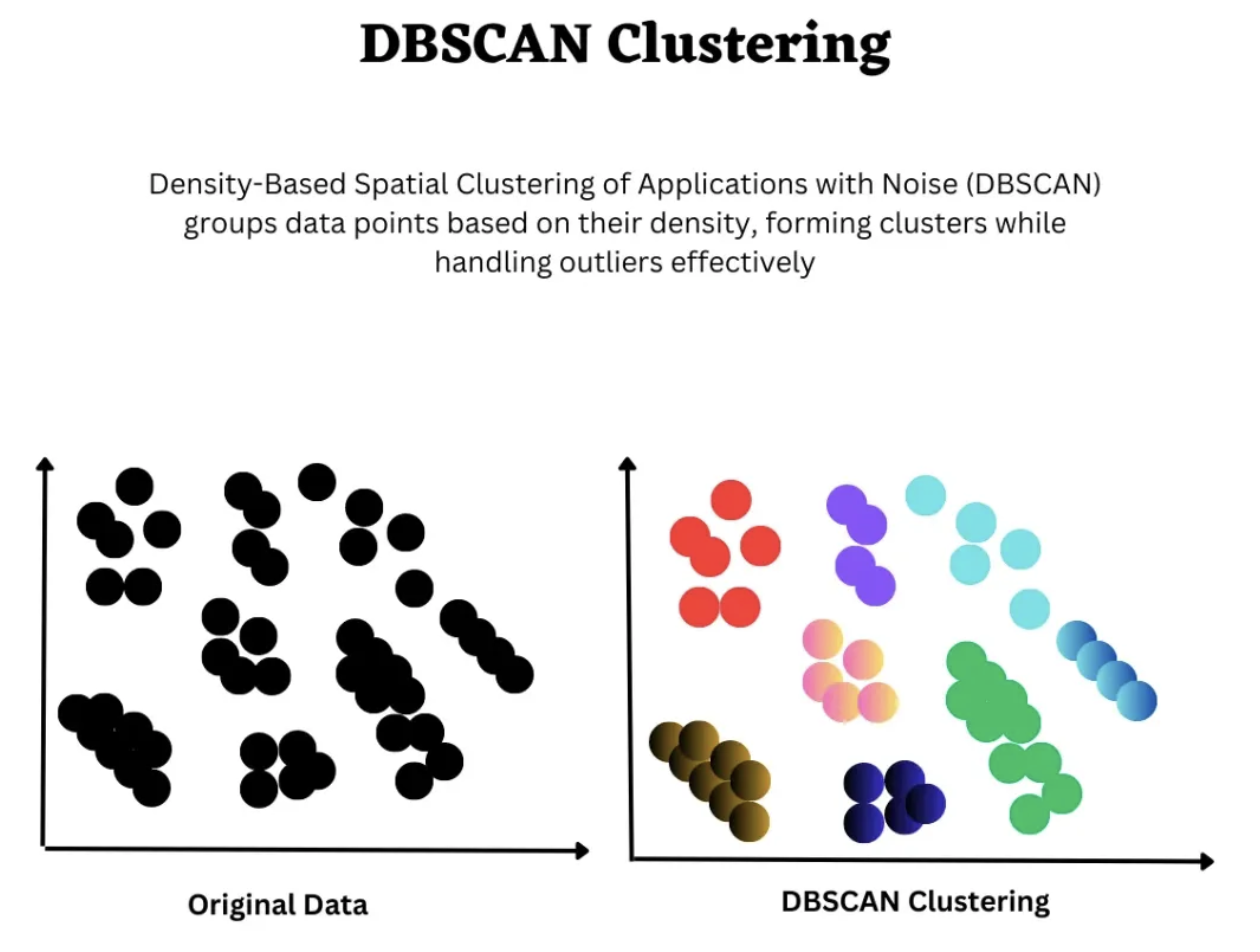

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a powerful unsupervised learning algorithm that groups data points into clusters based on density. It does **not require specifying the number of clusters** and can effectively detect **outliers** as noise.


Cloning into 'INDE577_ML_Rice_2025'...
remote: Enumerating objects: 363, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 363 (delta 11), reused 4 (delta 4), pack-reused 336 (from 1)
Receiving objects: 100% (363/363), 16.68 MiB | 17.41 MiB/s, done.
Resolving deltas: 100% (177/177), done.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


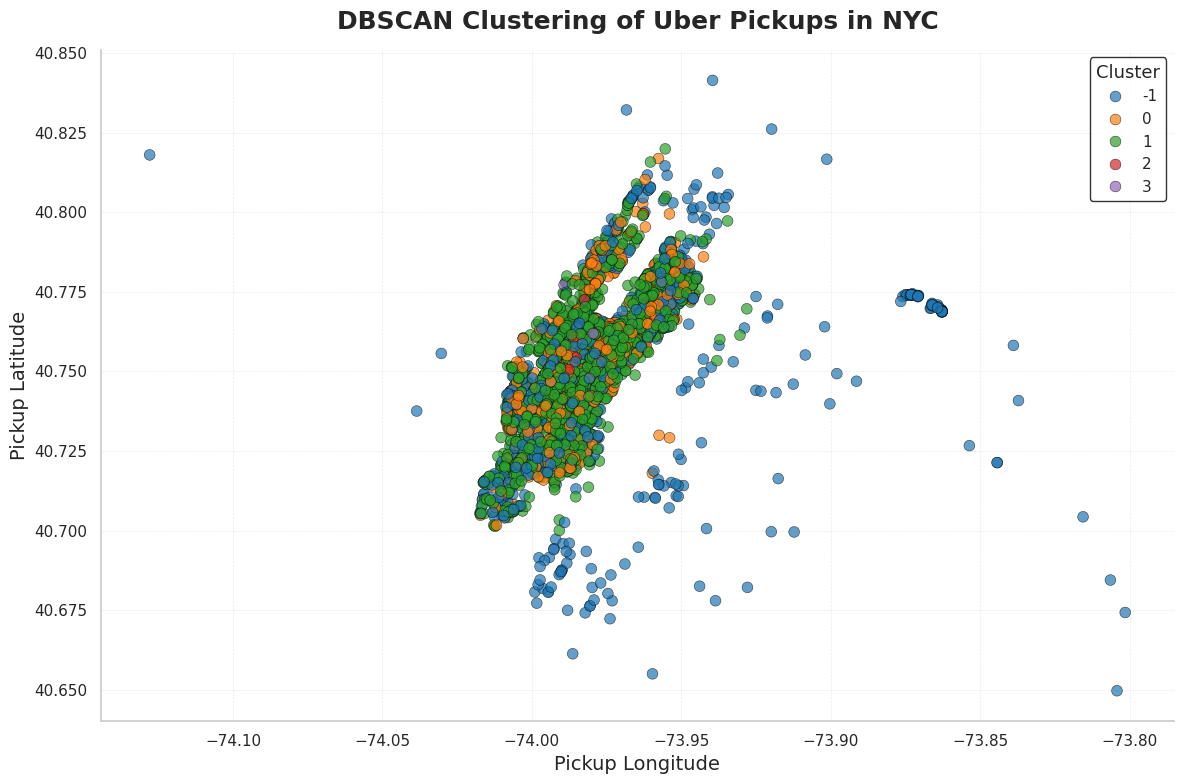

In [2]:
# Step 1: Clone your GitHub repo and import DBSCAN model
!rm -rf INDE577_ML_Rice_2025
!git clone https://github.com/alicewang777/INDE577_ML_Rice_2025.git

import sys
sys.path.append('/content/INDE577_ML_Rice_2025')
from rice_ml.dbscan import DBSCAN

# Step 2: Load packages and dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Step 3: Load and preprocess the Uber dataset
from google.colab import drive
drive.mount('/content/drive')

csv_path = "/content/drive/MyDrive/Colab Notebooks/ML_Rice_2025_Final_Project/uber.csv"
df = pd.read_csv(csv_path)
df = df[(df['pickup_longitude'] != 0) & (df['dropoff_longitude'] != 0)]
df = df[df['fare_amount'] < 100]
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna()

# Sample for efficiency
df = df.sample(n=3000, random_state=42)

# Step 4: Feature engineering
df['minute'] = df['pickup_datetime'].dt.minute
df['hour_exact'] = df['pickup_datetime'].dt.hour + df['minute'] / 60.0
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

df['manhattan_distance'] = (
    np.abs(df['pickup_longitude'] - df['dropoff_longitude']) +
    np.abs(df['pickup_latitude'] - df['dropoff_latitude'])
)
df['hour_passenger'] = df['hour_exact'] * df['passenger_count']

df = df[
    (df['pickup_longitude'] > -75) & (df['pickup_longitude'] < -73.8) &
    (df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 41)
]

# Step 5: Define clustering features
features = [
    'pickup_longitude', 'pickup_latitude',
    'hour_exact', 'minute', 'dayofweek', 'is_weekend',
    'passenger_count', 'manhattan_distance', 'hour_passenger'
]
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Apply DBSCAN clustering
model = DBSCAN(eps=1.2, min_samples=10)
model.fit(X_scaled)
df['cluster'] = model.labels_

# Step 7: Visualize clustering result (projected on spatial map)
import matplotlib.pyplot as plt
import seaborn as sns

# Set style and context
sns.set(style="whitegrid", context="notebook")

# Define number of clusters (including noise)
num_clusters = len(np.unique(df['cluster']))
palette = sns.color_palette("tab10", n_colors=num_clusters)

# Create figure
plt.figure(figsize=(12, 8), facecolor="white")
scatter = sns.scatterplot(
    x=df['pickup_longitude'],
    y=df['pickup_latitude'],
    hue=df['cluster'],
    palette=palette,
    s=60,
    alpha=0.7,
    edgecolor='black',
    linewidth=0.4
)

# Customize legend
plt.legend(
    title='Cluster',
    title_fontsize=13,
    fontsize=11,
    loc='best',
    frameon=True,
    facecolor='white',
    edgecolor='black'
)

# Add title and labels
plt.title("DBSCAN Clustering of Uber Pickups in NYC", fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Pickup Longitude", fontsize=14)
plt.ylabel("Pickup Latitude", fontsize=14)

# Improve layout
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()



In [3]:
import folium
from folium.plugins import MarkerCluster

# Create a base map centered on NYC
m = folium.Map(location=[40.75, -73.97], zoom_start=12, tiles='CartoDB positron')

# Define a colormap for clusters (including noise)
cluster_labels = sorted(df['cluster'].unique())
color_list = sns.color_palette("Set1", n_colors=len(cluster_labels)).as_hex()
color_map = {label: color_list[i] for i, label in enumerate(cluster_labels)}

# Add clustered points to the map
marker_cluster = MarkerCluster().add_to(m)

for _, row in df.iterrows():
    label = row['cluster']
    folium.CircleMarker(
        location=[row['pickup_latitude'], row['pickup_longitude']],
        radius=3,
        color=color_map[label],
        fill=True,
        fill_color=color_map[label],
        fill_opacity=0.6,
        weight=0.2,
        popup=f"Cluster: {label}"
    ).add_to(marker_cluster)

# Display the map
m


## Interpretation of DBSCAN Clustering on Uber Pickups

### Overview

I applied the **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** algorithm to NYC Uber pickup data, using both spatial (longitude, latitude) and temporal features (hour, passenger count, etc.). The goal was to uncover naturally occurring clusters in rider behavior without predefining the number of clusters.

---

### Static Spatial Plot

The scatter plot shows clustered pickups projected onto a 2D map using latitude and longitude. Key observations:

- **Dense areas** around midtown and downtown Manhattan are grouped into meaningful clusters (e.g., clusters 0, 1, 2), reflecting high traffic and temporal consistency in demand.
- **Noise points** (labeled `-1`) are clearly identifiable—these are outliers that DBSCAN deemed not part of any high-density region.
- Some peripheral points (e.g., near Queens or Jersey) are sparsely distributed, explaining their classification as noise.
- The algorithm automatically identifies 4 valid clusters plus outliers—no need to specify `k`.

---

### Interactive Map View

This interactive map overlays cluster density onto a real NYC map, providing geospatial context:

- **Clusters are visually concentrated around core business and transit zones**, including Times Square, Wall Street, and major transit hubs.
- **Color intensity and bubble size reflect pickup volume**, helping us spot **pickup hotspots** at a glance.
- Clusters extending into Brooklyn, Queens, and the Bronx are smaller and more dispersed, indicating lower demand consistency.
- The combination of **spatial and behavioral features** (e.g., time, passenger count) helps DBSCAN uncover not just *where* pickups happen, but *how* and *when* people ride.

---

### Conclusion

Together, these visualizations demonstrate how DBSCAN effectively segments urban mobility patterns without requiring prior knowledge of the number of clusters. It not only isolates dense areas but also flags unusual pickup behavior, aiding in **demand forecasting**, **fleet allocation**, and **urban planning**.